In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled)


In [2]:
%matplotlib inline
import utils_modified; reload(utils_modified)
from utils_modified import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
import numpy as np
import random
import sys

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Activation, LSTM, merge, Flatten, Dropout, Lambda
from keras.models import Model, Sequential
from keras.engine.topology import Merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import *
from keras.utils.data_utils import get_file

In [5]:
# https://keras.io/getting-started/sequential-model-guide/

In [6]:
# https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read()#.lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

corpus length: 600901
total chars: 85
nb sequences: 200287


In [7]:
lag = 6

In [8]:
idx = [char_indices[c] for c in text]

Xs = []
for l in range(lag):
    cdat = [idx[i+l] for i in xrange(0, len(idx)-1-lag, lag)]
    X = np.stack(cdat[:-2])
    Xs.append(X)

cdat = [idx[i+(l+1)] for i in xrange(0, len(idx)-1-lag, lag)]
Y = np.stack(cdat[:-2])

### Utility to inspect model predictive power

In [ ]:
def show_top_next(mdl, inp):
    pad_inp = (' '*lag)+inp
    idxs = [char_indices[c] for c in pad_inp][-lag:]
    ps = mdl.predict([np.array([i]) for i in idxs])
    probas = ps[0]/np.sum(ps)
    for i in range(5):
        index = np.random.choice(range(len(chars)), size=None, replace=True, p=probas)
        print(inp+chars[index])
    print('')
    
teststrs = ['this i','hersel','himsel','moral','moralit','knowledg','logica','hypothesi']

### Unrolled RNN built with a loop

In [ ]:
hdim = 250

In [38]:
def Maker1():
    inputs = [Input(shape=(1,), dtype='int64') for i in range(lag)]

    E = Embedding(output_dim=hdim, input_dim=len(chars), input_length=1)

    Di2h = Dense(hdim, activation='relu')
    Dh2h = Dense(hdim, activation='relu', init='identity')

    #hidden = ... CONSTANT ZERO TENSOR IN KERAS ?

    e = Di2h(Flatten()(E(inputs[0])))
    hidden = e
    for i in range(1,lag):
        e = Di2h(Flatten()(E(inputs[i])))
        hidden = merge([e, Dh2h(hidden)], mode='sum')
    predictions = Dense(len(chars), activation='softmax')(hidden)

    model = Model(input=inputs, output=predictions)

    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model1 = Maker1()

In [39]:
model1.optimizer.lr = 1e-3
hist1 = model1.fit(Xs, to_categorical(Y,len(chars)), batch_size=100, nb_epoch=15)

Epoch 1/15
100147/100147 [==============================] - 7s - loss: 2.4770 - acc: 0.2992     
Epoch 2/15
100147/100147 [==============================] - 7s - loss: 2.1802 - acc: 0.3721     
Epoch 3/15
100147/100147 [==============================] - 7s - loss: 2.0821 - acc: 0.4013     
Epoch 4/15
100147/100147 [==============================] - 7s - loss: 2.0155 - acc: 0.4189     
Epoch 5/15
100147/100147 [==============================] - 7s - loss: 1.9661 - acc: 0.4329     
Epoch 6/15
100147/100147 [==============================] - 7s - loss: 1.9227 - acc: 0.4433     
Epoch 7/15
100147/100147 [==============================] - 7s - loss: 1.8880 - acc: 0.4531     
Epoch 8/15
100147/100147 [==============================] - 7s - loss: 1.8595 - acc: 0.4603     
Epoch 9/15
100147/100147 [==============================] - 7s - loss: 1.8358 - acc: 0.4661     
Epoch 10/15
100147/100147 [==============================] - 7s - loss: 1.8130 - acc: 0.4715     
Epoch 11/15
100147/100147 [==

In [43]:
for teststr in teststrs:
    show_top_next(model1, teststr)

this in
this ig
this in
this ic
this in

herseli
hersel:
herseli
herselt
hersell

himself
himself
himself
himself
himself

moral"
morali
moraly
morali
moral 

morality
morality
morality
morality
morality

knowledge
knowledge
knowledge
knowledge
knowledge

logicab
logical
logical
logical
logical

hypothesiv
hypothesis
hypothesim
hypothesis
hypothesim



### Unrolled RNN with BatchNormalization

In [40]:
def Maker2():
    inputs = [Input(shape=(1,), dtype='int64') for i in range(lag)]

    E = Embedding(output_dim=hdim, input_dim=len(chars), input_length=1)

    Di2h = Dense(hdim, activation='relu')
    Dh2h = Dense(hdim, activation='relu', init='identity')

    #hidden = ... CONSTANT ZERO TENSOR IN KERAS ?
    
    e = Di2h(Flatten()(E(inputs[0])))
    hidden = BatchNormalization()(e)
    for i in range(1,lag):
        e = Di2h(Flatten()(E(inputs[i])))
        hidden = merge([BatchNormalization()(e), Dh2h(hidden)], mode='sum')
    predictions = Dense(len(chars), activation='softmax')(hidden)

    model = Model(input=inputs, output=predictions)

    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model2 = Maker2()

In [41]:
model2.optimizer.lr = 1e-3
hist2 = model2.fit(Xs, to_categorical(Y,len(chars)), batch_size=100, nb_epoch=15)

Epoch 1/15
100147/100147 [==============================] - 18s - loss: 2.3919 - acc: 0.3251    
Epoch 2/15
100147/100147 [==============================] - 18s - loss: 2.1572 - acc: 0.3842    
Epoch 3/15
100147/100147 [==============================] - 18s - loss: 2.0616 - acc: 0.4096    
Epoch 4/15
100147/100147 [==============================] - 18s - loss: 1.9904 - acc: 0.4274    
Epoch 5/15
100147/100147 [==============================] - 18s - loss: 1.9359 - acc: 0.4401    
Epoch 6/15
100147/100147 [==============================] - 18s - loss: 1.8863 - acc: 0.4532    
Epoch 7/15
100147/100147 [==============================] - 18s - loss: 1.8487 - acc: 0.4613    
Epoch 8/15
100147/100147 [==============================] - 18s - loss: 1.8188 - acc: 0.4695    
Epoch 9/15
100147/100147 [==============================] - 18s - loss: 1.7861 - acc: 0.4782    
Epoch 10/15
100147/100147 [==============================] - 18s - loss: 1.7590 - acc: 0.4845    
Epoch 11/15
100147/100147 [==

In [42]:
for teststr in teststrs:
    show_top_next(model2, teststr)

this it
this in
this in
this in
this ig

hersela
hersels
hersela
hersels
hersel,

himself
himself
himself
himself
himself

morale
moral 
moral 
moralv
moral 

morality
morality
morality
morality
moralits

knowledge
knowledge
knowledge
knowledge
knowledge

logical
logical
logical
logical
logical

hypothesim
hypothesin
hypothesis
hypothesis
hypothesit



### Compare training convergence of the 2 models

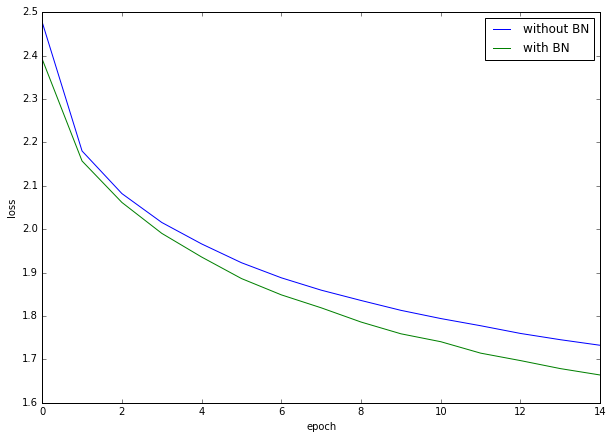

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(hist1.history['loss'])
plt.plot(hist2.history['loss'])
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['without BN','with BN'], loc='upper right')
plt.show()